In [ ]:

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import sys
import os
import access_era_5 as access_era_5
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

sys.path.append(os.path.abspath(".."))

from utils.lstmModel import LstmModel
import utils.lstm as lstm


2025-09-29 18:27:06.344081: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


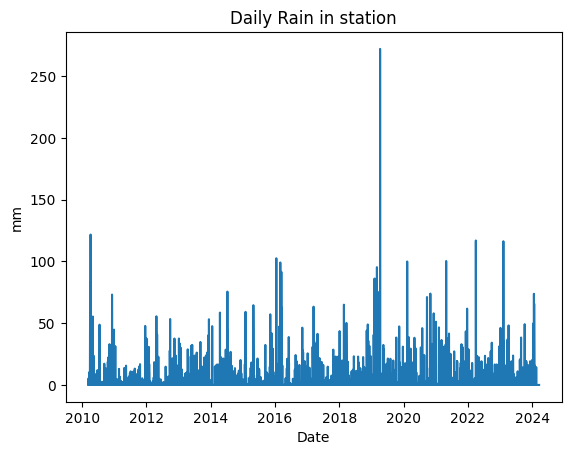

In [ ]:
timeseries = access_era_5.recuperar_dados_era_5()
dias = timeseries['valid_time']

total_chuva = timeseries['tp']
dias = pd.to_datetime(dias)

# Faz o plot
plt.figure(figsize=(12,6))
plt.plot(dias, total_chuva, marker="o", linestyle="-")

plt.title("Daily Rain in station", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Precipitation (mm)", fontsize=12)
plt.grid(True)
plt.show()


In [ ]:
lookback = 30
X, y = lstm.create_sequences_pytorch(total_chuva, lookback=lookback)
train_size = int(len(timeseries) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


dates_aligned = dias[lookback:]
train_date, test_date = dates_aligned[:train_size] , dates_aligned[train_size:]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

/home/pbose/tcc/pesquisa/utils/lstm.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i+lookback])


In [11]:

# Building the model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(lookback, 1)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(1))  


model.compile(optimizer="adam", loss="mse")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

# --- Previsão ---
pred = model.predict(X_test)
#pred_rescaled = scaler.inverse_transform(pred)
#real_rescaled = scaler.inverse_transform(y_test)

Epoch 1/20


/home/pbose/tcc/pesquisa/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 89.4790 - val_loss: 92.8910
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 88.2556 - val_loss: 92.2938
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 87.5909 - val_loss: 91.5874
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 87.5073 - val_loss: 92.5980
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 87.4043 - val_loss: 92.4760
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 87.2520 - val_loss: 92.4321
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 86.8108 - val_loss: 92.9828
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 86.6530 - val_loss: 91.5640
Epoch 9/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 86.6548 - val_loss: 92.6554
Epoch 10/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 86.6717 - val_loss: 92.0230
Epoch 11/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 85.9246 - val_loss: 92.2398
Epoch 12/20
112/112 ━━━━━━━━━━

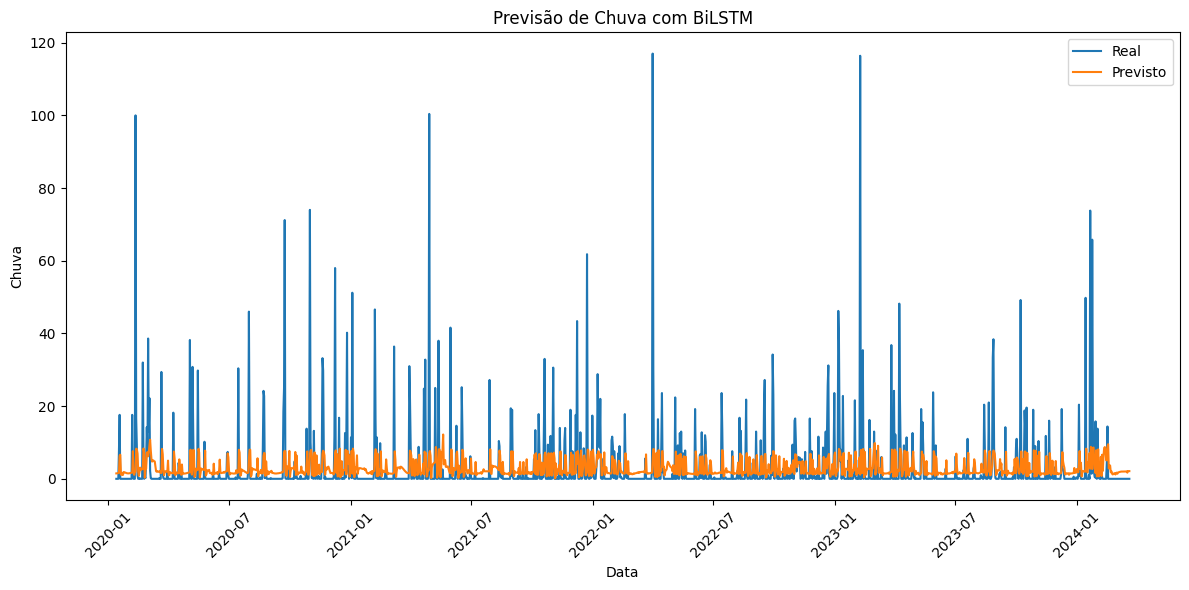

In [14]:
plt.figure(figsize=(12,6))
plt.plot(test_date, y_test, label="Real")
plt.plot(test_date, pred, label="Previsto")
plt.legend()
plt.title("Previsão de Chuva com BiLSTM")
plt.xlabel("Data")
plt.ylabel("Chuva")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()